# Running a forward pass through LeNet using MNIST and Joey

In this example, we will construct LeNet using Joey, set it up with pretrained parameters and run a forward pass through it with test data from MNIST. The results will be compared to the PyTorch ones to confirm Joey's numerical correctness.

Firstly, let's import all the prerequisites:

In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import joey as ml
from joey.activation import ReLU

We'll define `imshow()` to quickly have a look at the MNIST data we'll use for the forward pass.

In [12]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Before we start working with Joey, we have to download the images and convert them to NumPy arrays with `dtype=np.float64`. This is because Joey supports only NumPy arrays (rather than PyTorch tensors) and it currently works with double floating-point numbers.

In our case, a batch will consist of 4 elements.

In [13]:
transform = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
testset = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
dataiter = iter(testloader)

images, labels = dataiter.next()
input_data = images.double().numpy()

Let's have a look at what we've downloaded:

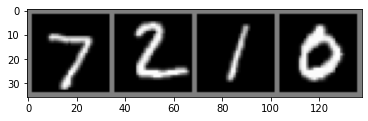

In [14]:
imshow(torchvision.utils.make_grid(images))

Now, we'll define `forward_pass()`. It creates LeNet using the `Net` class in Joey along with appropriate layer classes (here: `Conv`, `MaxPooling`, `Flat` and `FullyConnected`). Afterwards, by accessing the `kernel` and `bias` properties of each relevant layer, it inserts the pretrained weights saved in `.npy` files inside `resources/`.

Note that we have to disable a strict stride check in `layer4`. If we didn't do that, we would get an error saying the stride is incompatible with the provided kernel and input sizes.

In [15]:
def forward_pass(input_data):
    parameters = get_parameters()
    
    batch_size = 4
    
    # Six 3x3 filters, activation RELU
    layer1 = ml.Conv(kernel_size=(6, 3, 3),
                     input_size=(batch_size, 1, 32, 32),
                     activation=ReLU())
    # 2x2 max pooling
    layer2 = ml.MaxPooling(kernel_size=(2, 2),
                           input_size=(batch_size, 6, 30, 30),
                           stride=(2, 2))
    # Sixteen 3x3 filters, activation RELU
    layer3 = ml.Conv(kernel_size=(16, 3, 3),
                     input_size=(batch_size, 6, 15, 15),
                     activation=ReLU())
    # 2x2 max pooling
    layer4 = ml.MaxPooling(kernel_size=(2, 2),
                           input_size=(batch_size, 16, 13, 13),
                           stride=(2, 2),
                           strict_stride_check=False)
    # Full connection (16 * 6 * 6 -> 120), activation RELU
    layer5 = ml.FullyConnected(weight_size=(120, 576),
                               input_size=(576, batch_size),
                               activation=ReLU())
    # Full connection (120 -> 84), activation RELU
    layer6 = ml.FullyConnected(weight_size=(84, 120),
                               input_size=(120, batch_size),
                               activation=ReLU())
    # Full connection (84 -> 10), output layer
    layer7 = ml.FullyConnected(weight_size=(10, 84),
                               input_size=(84, batch_size))
    # Flattening layer necessary between layer 4 and 5
    layer_flat = ml.Flat(input_size=(batch_size, 16, 6, 6))
    
    layers = [layer1, layer2, layer3, layer4,
              layer_flat, layer5, layer6, layer7]
    
    net = ml.Net(layers)
    
    # Setting up the pretrained parameters
    layer1.kernel.data[:] = parameters[0]
    layer1.bias.data[:] = parameters[1]
    
    layer3.kernel.data[:] = parameters[2]
    layer3.bias.data[:] = parameters[3]
    
    layer5.kernel.data[:] = parameters[4]
    layer5.bias.data[:] = parameters[5]
    
    layer6.kernel.data[:] = parameters[6]
    layer6.bias.data[:] = parameters[7]
    
    layer7.kernel.data[:] = parameters[8]
    layer7.bias.data[:] = parameters[9]
    
    net.forward(input_data)
    
    return (layer1, layer2, layer3, layer4, layer5, layer6, layer7)

def get_parameters():
    # The LeNet pretrained parameters are stored in the following files:
    # 1.npy: layer 1 weights
    # 2.npy: layer 1 biases
    # 3.npy: layer 3 weights
    # 4.npy: layer 3 biases
    # 5.npy: layer 5 weights
    # 6.npy: layer 5 biases
    # 7.npy: layer 6 weights
    # 8.npy: layer 6 biases
    # 9.npy: layer 7 weights
    # 10.npy: layer 7 biases
    #
    # For layer numbering, see forward_pass().
    
    parameters = []
    path = './resources/'
    for i in range(10):
        to_add = np.load(path + str(i + 1) + '.npy')
        parameters.append(to_add)
    return parameters

At this point, we're ready to run the forward pass!

In [16]:
layer1, layer2, layer3, layer4, layer5, layer6, layer7 = forward_pass(input_data)

/var/folders/gg/vt085wyd2f71891zs2yw42fr0000gn/T/devito-jitcache-uid501/fad52ad15ef5d332f0aeae12af92b1892bff365f.c:262:49: warning: using floating point absolute value function 'fabs' when argument is of integer type [-Wabsolute-value]
              f105[d60][d61][d64][d65] = fmin(4*fabs((((f104 - f65[d60][d61][d64][d65]) > 0) - ((f104 - f65[d60][d61][d64][d65]) < 0))) + f105[d60][d61][d64][d65], 2*d96 + d97 + 4*fabs((((f64[d60][d61][2*d64 + d96][2*d65 + d97] - f65[d60][d61][d64][d65]) > 0) - ((f64[d60][d61][2*d64 + d96][2*d65 + d97] - f65[d60][d61][d64][d65]) < 0))));
                                                ^
/var/folders/gg/vt085wyd2f71891zs2yw42fr0000gn/T/devito-jitcache-uid501/fad52ad15ef5d332f0aeae12af92b1892bff365f.c:262:49: note: use function 'abs' instead
              f105[d60][d61][d64][d65] = fmin(4*fabs((((f104 - f65[d60][d61][d64][d65]) > 0) - ((f104 - f65[d60][d61][d64][d65]) < 0))) + f105[d60][d61][d64][d65], 2*d96 + d97 + 4*fabs((((f64[d60][d61][2*d64 + d96][2*d

After the pass is finished, we can access its output by checking the `result` property of the last layer.

In [17]:
output = layer7.result.data
print(output)

[[-1.25093235  2.40170754 -2.91894739 11.40261028]
 [-2.07392762  3.71119382 10.29915659 -3.86913358]
 [ 1.71857655 11.98346066  0.78475773 -0.83818808]
 [ 2.72902527  1.57888285 -2.29991193 -2.10936302]
 [-3.44730161 -0.97862156  0.74267698 -2.76126013]
 [-2.24625136 -6.90597038 -2.56770215  0.69071474]
 [-9.81793181 -1.31553492 -2.71544678  1.17052616]
 [11.80988846 -2.70283259  0.54783864  1.00494804]
 [-1.00474132 -2.48071229 -1.01346485 -1.28202689]
 [ 4.6835631  -6.38347289 -2.26087571 -0.76408295]]


The results look promising: for each batch element (arranged in columns rather than rows), the highest number corresponds to the expected class, i.e. '7' has been recognised as 7, '2' has been recognised as 2, '1' has been recognised as 1 and '0' has been recognised as 0.

For reference, we'll construct the same network with the same weights in PyTorch, run the pass there and compare the outputs.

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [19]:
net = Net()
net.double()

with torch.no_grad():
    net.conv1.weight[:] = torch.from_numpy(layer1.kernel.data)
    net.conv1.bias[:] = torch.from_numpy(layer1.bias.data)
    net.conv2.weight[:] = torch.from_numpy(layer3.kernel.data)
    net.conv2.bias[:] = torch.from_numpy(layer3.bias.data)
    net.fc1.weight[:] = torch.from_numpy(layer5.kernel.data)
    net.fc1.bias[:] = torch.from_numpy(layer5.bias.data)
    net.fc2.weight[:] = torch.from_numpy(layer6.kernel.data)
    net.fc2.bias[:] = torch.from_numpy(layer6.bias.data)
    net.fc3.weight[:] = torch.from_numpy(layer7.kernel.data)
    net.fc3.bias[:] = torch.from_numpy(layer7.bias.data)

pytorch_output = np.transpose(net(images.double()).detach().numpy())

After creating and running the network in PyTorch, we'll calculate a relative error matrix as shown below. The maximum value in that matrix will be obtained as well.

In [20]:
error = abs(output - pytorch_output) / abs(pytorch_output)

print(error)
print(np.nanmax(error))

[[3.55006577e-16 0.00000000e+00 1.52140190e-16 1.55785105e-16]
 [4.28259121e-16 2.39324181e-16 0.00000000e+00 2.29554860e-16]
 [7.75215762e-16 0.00000000e+00 1.83915350e-15 9.27185838e-16]
 [1.62728141e-16 1.40633997e-16 5.79268976e-16 4.21064754e-16]
 [2.57644535e-16 1.58826690e-15 1.19591483e-15 6.43313834e-16]
 [3.95404734e-16 0.00000000e+00 1.72951995e-16 1.60735389e-16]
 [0.00000000e+00 1.68786553e-16 3.27083715e-16 1.89696406e-16]
 [0.00000000e+00 1.64305112e-16 8.10620462e-16 0.00000000e+00]
 [8.83987149e-16 1.79016813e-16 2.19094530e-16 1.73198086e-16]
 [0.00000000e+00 2.78274361e-16 0.00000000e+00 4.35904122e-16]]
1.839153502987959e-15


As we can see, the maximum error is low enough (given the floating-point calculation accuracy) for the Joey results to be considered numerically correct.